In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import rasterio

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set specific GPU to be used (optional)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def unet_model_final(input_shape=(256, 256, 3), drop_rate=0.3, classes=11):
    # Define the input layer for the model with the specified input shape.
    inputs = Input(input_shape)

    # The first encoding block applies two convolutional layers followed by batch normalization,
    # and then downsamples the feature map using max pooling.
    enc1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    enc1 = BatchNormalization()(enc1)
    enc1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(enc1)
    enc1 = BatchNormalization()(enc1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(enc1)

    # The second encoding block doubles the number of filters, applies convolution + batch normalization,
    # and performs another max pooling operation.
    enc2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    enc2 = BatchNormalization()(enc2)
    enc2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(enc2)
    enc2 = BatchNormalization()(enc2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(enc2)

    # The third encoding block follows the same structure with 256 filters.
    enc3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    enc3 = BatchNormalization()(enc3)
    enc3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(enc3)
    enc3 = BatchNormalization()(enc3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(enc3)

    # The fourth encoding block increases the filters to 512 and includes dropout for regularization.
    enc4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    enc4 = BatchNormalization()(enc4)
    enc4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(enc4)
    enc4 = BatchNormalization()(enc4)
    drop4 = Dropout(drop_rate)(enc4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # The bottleneck block connects the encoder and decoder with the highest number of filters (1024),
    # along with dropout for regularization.
    bridge = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    bridge = BatchNormalization()(bridge)
    bridge = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(bridge)
    bridge = BatchNormalization()(bridge)
    drop_bridge = Dropout(drop_rate)(bridge)

    # The first decoding block upsamples the features and concatenates with the corresponding encoder block,
    # followed by two convolutional layers and batch normalization.
    up1 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop_bridge))
    merge1 = concatenate([drop4, up1])
    dec1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    dec1 = BatchNormalization()(dec1)
    dec1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(dec1)
    dec1 = BatchNormalization()(dec1)

    # The second decoding block uses features from the third encoder block and repeats the same structure.
    up2 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(dec1))
    merge2 = concatenate([enc3, up2])
    dec2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    dec2 = BatchNormalization()(dec2)
    dec2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(dec2)
    dec2 = BatchNormalization()(dec2)

    # The third decoding block uses features from the second encoder block.
    up3 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(dec2))
    merge3 = concatenate([enc2, up3])
    dec3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge3)
    dec3 = BatchNormalization()(dec3)
    dec3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(dec3)
    dec3 = BatchNormalization()(dec3)

    # The fourth decoding block uses features from the first encoder block.
    up4 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(dec3))
    merge4 = concatenate([enc1, up4])
    dec4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge4)
    dec4 = BatchNormalization()(dec4)
    dec4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(dec4)
    dec4 = BatchNormalization()(dec4)

    # The output layer uses a 1x1 convolution to map features to the desired number of classes,
    # with softmax activation for multi-class segmentation.
    outputs = Conv2D(classes, 1, activation='softmax')(dec4)

    # Define and compile the U-Net model with the Adam optimizer and categorical crossentropy loss.
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [6]:
import os
import numpy as np
import cv2
import rasterio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

class SemanticImageSegmentation:
    def __init__(self, img_rows=256, img_cols=256, drop_rate=0.5):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.drop_rate = drop_rate
        self.num_channels = 3  # Optical imagery (RGB)
        self.model = None
        
        # ESA WorldCover class definitions
        self.class_definitions = {
            'trees': 10,
            'shrubland': 20,
            'grassland': 30,
            'cropland': 40,
            'built_up': 50,
            'bare': 60,
            'snow': 70,
            'water': 80,
            'wetland': 90,
            'mangroves': 95,
            'moss': 100
        }
        self.num_classes = len(self.class_definitions)

    def one_hot_encode(self, labels):
        """Convert ESA WorldCover labels to one-hot encoded format"""
        encoded = np.zeros((labels.shape[0], labels.shape[1], self.num_classes))
        for i, value in enumerate(sorted(self.class_definitions.values())):
            encoded[:, :, i] = (labels == value)
        return encoded

    def load_optical_data(self, file_path):
        """Load optical imagery from various formats"""
        with rasterio.open(file_path) as src:
            optical_data = src.read([1, 2, 3])  # Read RGB bands
            optical_data = np.transpose(optical_data, (1, 2, 0))  # Reshape to HWC format
            optical_data = cv2.resize(optical_data, (self.img_cols, self.img_rows))
        return optical_data

    def preprocess_optical(self, optical_data):
        """Preprocess optical imagery"""
        return optical_data / 255.0  # Normalize to [0, 1]

    def load_data(self, optical_dir, label_dir):
        """Load all optical and label data from directories"""
        optical_files = sorted([os.path.join(optical_dir, f) for f in os.listdir(optical_dir) if f.endswith('.tif')])
        label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.tif')])
        assert len(optical_files) == len(label_files), "Number of optical and label files must match"
        return optical_files, label_files

    def train(self, optical_dir, label_dir, validation_split=0.2, test_split=0.1, batch_size=4, epochs=100):
        print('Loading data...')
        optical_files, label_files = self.load_data(optical_dir, label_dir)
        
        # Split files into train, validation, and test sets
        train_optical_files, temp_optical_files, train_label_files, temp_label_files = train_test_split(
            optical_files, label_files, test_size=validation_split + test_split, random_state=42)
        
        val_optical_files, test_optical_files, val_label_files, test_label_files = train_test_split(
            temp_optical_files, temp_label_files, test_size=test_split / (validation_split + test_split), random_state=42)
        
        def data_generator(optical_files, label_files, batch_size):
            while True:
                indices = np.random.permutation(len(optical_files))
                for start in range(0, len(indices), batch_size):
                    batch_indices = indices[start:start + batch_size]
                    batch_x = np.zeros((len(batch_indices), self.img_rows, self.img_cols, self.num_channels))
                    batch_y = np.zeros((len(batch_indices), self.img_rows, self.img_cols, self.num_classes))
                    
                    for i, idx in enumerate(batch_indices):
                        optical_data = self.load_optical_data(optical_files[idx])
                        batch_x[i] = self.preprocess_optical(optical_data)
                        
                        with rasterio.open(label_files[idx]) as src:
                            label = src.read(1)
                            label = cv2.resize(label, (self.img_cols, self.img_rows), interpolation=cv2.INTER_NEAREST)
                            batch_y[i] = self.one_hot_encode(label)
                    yield batch_x, batch_y
        
        train_generator = data_generator(train_optical_files, train_label_files, batch_size)
        val_generator = data_generator(val_optical_files, val_label_files, batch_size)
        
        steps_per_epoch = len(train_optical_files) // batch_size
        validation_steps = len(val_optical_files) // batch_size
        
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        self.model = unet_model_final(input_shape=(self.img_rows, self.img_cols, self.num_channels), classes=self.num_classes)
        
        callbacks = [
            ModelCheckpoint('weights/unet_best_optical.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True),
            EarlyStopping(patience=10, monitor='val_loss')
        ]
        
        history = self.model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=validation_steps,
            callbacks=callbacks
        )
                # Create the directory if it doesn't exist
        os.makedirs("models", exist_ok=True)


        # ✅ Save the **entire model** in TensorFlow format
        self.model.save('models/unet_best_optical24_tf.keras')
        print("✅ Model saved successfully in SavedModel format!")
        return history

    def predict(self, optical_data):
        if self.model is None:
            raise ValueError("Model not trained. Call train() first or load a trained model.")
        optical_processed = self.preprocess_optical(optical_data)
        if len(optical_processed.shape) == 3:
            optical_processed = np.expand_dims(optical_processed, axis=0)
        return self.model.predict(optical_processed)
    
    def load_trained_model(self, model_path):
        self.model = unet_model_final(input_shape=(self.img_rows, self.img_cols, self.num_channels), classes=self.num_classes)
        self.model.load_weights(model_path)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [7]:
def visualize_prediction(prediction, original_optical=None):
    """Visualize segmentation prediction with ESA WorldCover colors"""
    # ESA WorldCover colors
    colors = {
        0: [0, 100, 0],     # Trees - Dark green
        1: [255, 165, 0],   # Shrubland - Orange
        2: [144, 238, 144], # Grassland - Light green
        3: [255, 255, 0],   # Cropland - Yellow
        4: [255, 0, 0],     # Built-up - Red
        5: [139, 69, 19],   # Bare - Brown
        6: [255, 255, 255], # Snow - White
        7: [0, 0, 255],     # Water - Blue
        8: [0, 139, 139],   # Wetland - Dark cyan
        9: [0, 255, 0],     # Mangroves - Bright green
        10: [220, 220, 220] # Moss - Light grey
    }
    
    # Convert prediction to color image
    pred_class = np.argmax(prediction[0], axis=-1)
    colored_pred = np.zeros((pred_class.shape[0], pred_class.shape[1], 3), dtype=np.uint8)
    
    for class_idx, color in colors.items():
        colored_pred[pred_class == class_idx] = color
    
    # Display
    plt.figure(figsize=(12, 4))
    
    if original_optical is not None:
        plt.subplot(131)
        plt.title('Original Optical')
        plt.imshow(original_optical[:,:,0], cmap='gray')
        plt.axis('off')
        
        plt.subplot(132)
        plt.title('Prediction')
        plt.imshow(colored_pred)
        plt.axis('off')
        
        plt.subplot(133)
        plt.title('Overlay')
        overlay = cv2.addWeighted(
            cv2.cvtColor(original_optical[:,:,0], cv2.COLOR_GRAY2RGB),
            0.7,
            colored_pred,
            0.3,
            0
        )
        plt.imshow(overlay)
        plt.axis('off')
    else:
        plt.imshow(colored_pred)
        plt.axis('off')
        plt.title('Prediction')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Initialize the segmentation model
    segmentation = SemanticImageSegmentation(
        img_rows=256,
        img_cols=256,
        drop_rate=0.5
    )
    
    # Train the model
    history = segmentation.train(
        optical_dir='/kaggle/input/kaggle/original_patches',
        label_dir='/kaggle/input/kaggle/label_patches',
        validation_split=0.2,
        batch_size=4,
        epochs=100
    )
    
    # Plot training history
    plot_training_history(history)


Loading data...


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/kaggle/original_patches'

In [ ]:
segmentation = SemanticImageSegmentation(
    img_rows=256,
    img_cols=256,
    drop_rate=0.5
)


In [ ]:
from tensorflow import keras

# Load the model
segmentation_model = keras.models.load_model('/kaggle/input/models/unet_best_optical24_tf.keras')

# Assign to segmentation object (this is missing in your code)
segmentation.model = segmentation_model  # Ensure it's stored correctly

print(f"✅ Model assigned successfully: {segmentation.model}")  # Now should NOT print None


✅ Model assigned successfully: <Functional name=functional, built=True>


In [ ]:
print(f"Segmentation model: {segmentation.model}")


Segmentation model: <Functional name=functional, built=True>


In [ ]:
optical_dir = "/kaggle/input/kaggle/original_patches"  # Update with actual directory
label_dir = "/kaggle/input/kaggle/label_patches"  # Update with actual directory

# Now load the data
optical_files, label_files = segmentation.load_data(optical_dir, label_dir)


In [ ]:
# Load data without training
optical_files, label_files = segmentation.load_data(optical_dir, label_dir)

# Split files into train, validation, and test sets
train_optical_files, temp_optical_files, train_label_files, temp_label_files = train_test_split(
    optical_files, label_files, test_size=0.3, random_state=42)  # 0.3 = validation + test

val_optical_files, test_optical_files, val_label_files, test_label_files = train_test_split(
    temp_optical_files, temp_label_files, test_size=1/3, random_state=42)  # 1/3 of 0.3 = 0.1 test

# Now test_optical_files is available
print("Total test images:", len(test_optical_files))
print("Sample test image path:", test_optical_files[0] if test_optical_files else "No test images found")


Total test images: 395
Sample test image path: /kaggle/input/kaggle/original_patches/assalu_patch_937.tif


In [ ]:
print(f"Total Images: {len(optical_files)}")
print(f"Train Set: {len(train_optical_files)} images")
print(f"Validation Set: {len(val_optical_files)} images")
print(f"Test Set: {len(test_optical_files)} images")

# Print first few file names
print("Train Samples:", train_optical_files[:3])
print("Validation Samples:", val_optical_files[:3])
print("Test Samples:", test_optical_files[:3])


Total Images: 3942
Train Set: 2759 images
Validation Set: 788 images
Test Set: 395 images
Train Samples: ['/kaggle/input/kaggle/original_patches/assalu_patch_2231.tif', '/kaggle/input/kaggle/original_patches/assalu_patch_1099.tif', '/kaggle/input/kaggle/original_patches/assalu_patch_3230.tif']
Validation Samples: ['/kaggle/input/kaggle/original_patches/assalu_patch_606.tif', '/kaggle/input/kaggle/original_patches/assalu_patch_2382.tif', '/kaggle/input/kaggle/original_patches/assalu_patch_2705.tif']
Test Samples: ['/kaggle/input/kaggle/original_patches/assalu_patch_937.tif', '/kaggle/input/kaggle/original_patches/assalu_patch_1051.tif', '/kaggle/input/kaggle/original_patches/assalu_patch_959.tif']


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Test Image 1: /kaggle/input/kaggle/original_patches/assalu_patch_937.tif
Label Image 1: /kaggle/input/kaggle/label_patches/label_patch_937.tif
Predicted class shape: (256, 256)


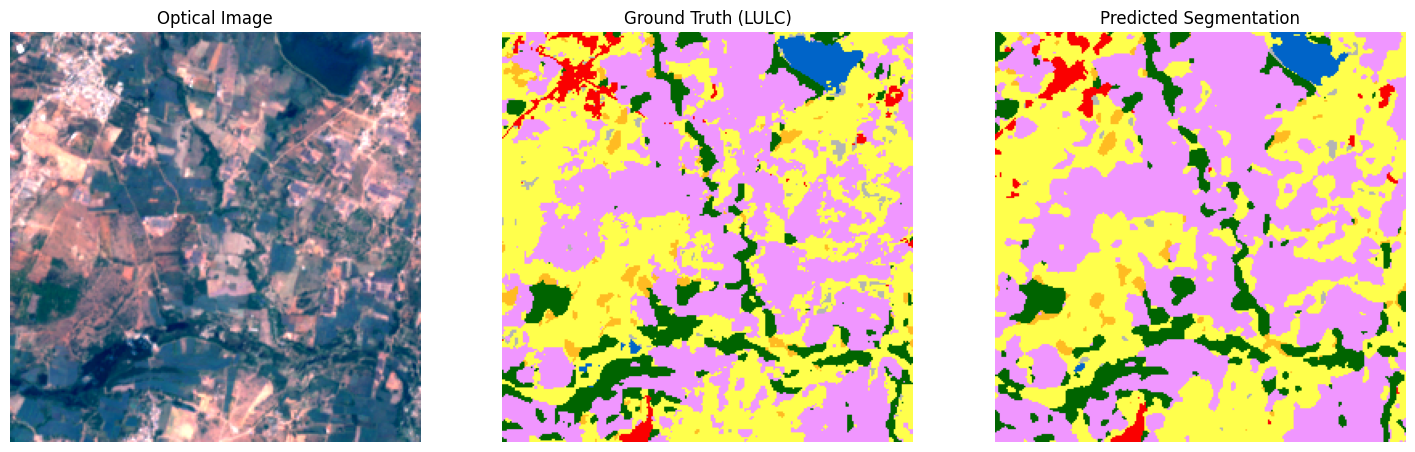

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test Image 2: /kaggle/input/kaggle/original_patches/assalu_patch_1051.tif
Label Image 2: /kaggle/input/kaggle/label_patches/label_patch_1051.tif
Predicted class shape: (256, 256)


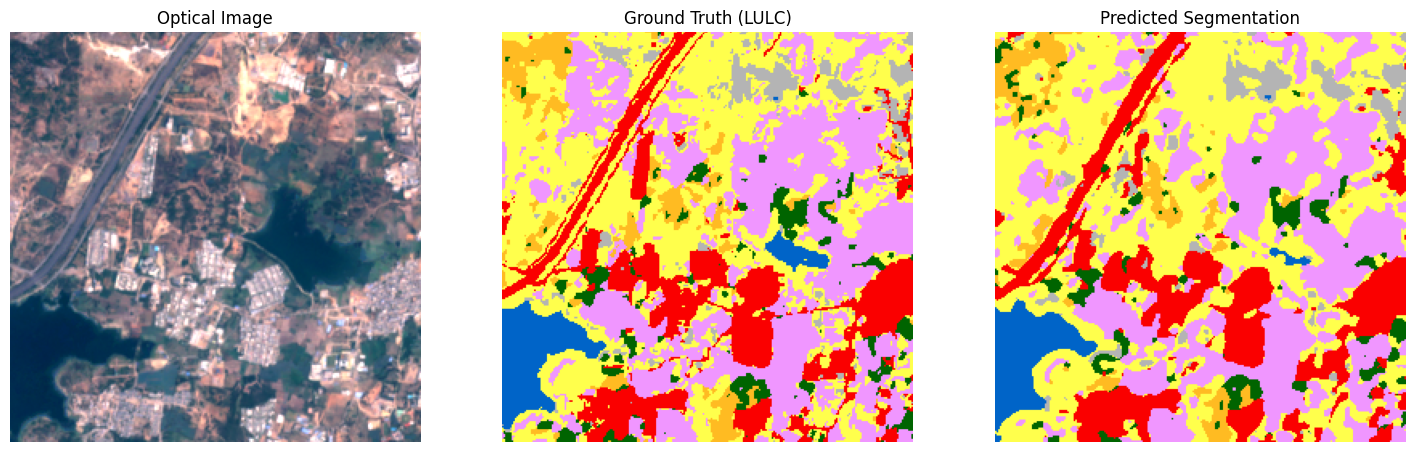

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test Image 3: /kaggle/input/kaggle/original_patches/assalu_patch_959.tif
Label Image 3: /kaggle/input/kaggle/label_patches/label_patch_959.tif
Predicted class shape: (256, 256)


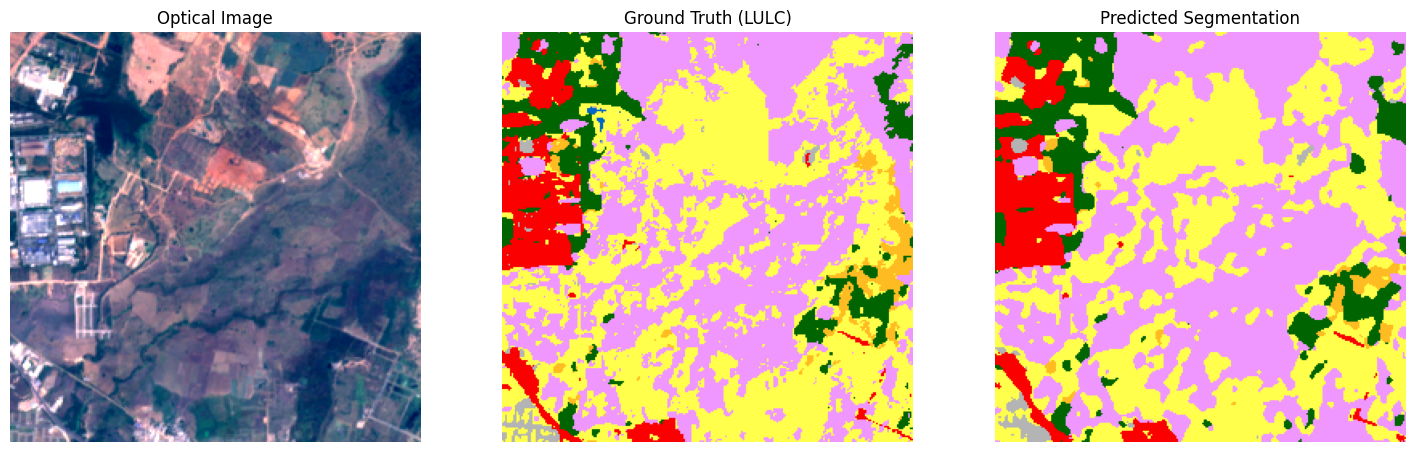

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test Image 4: /kaggle/input/kaggle/original_patches/assalu_patch_3374.tif
Label Image 4: /kaggle/input/kaggle/label_patches/label_patch_3374.tif
Predicted class shape: (256, 256)


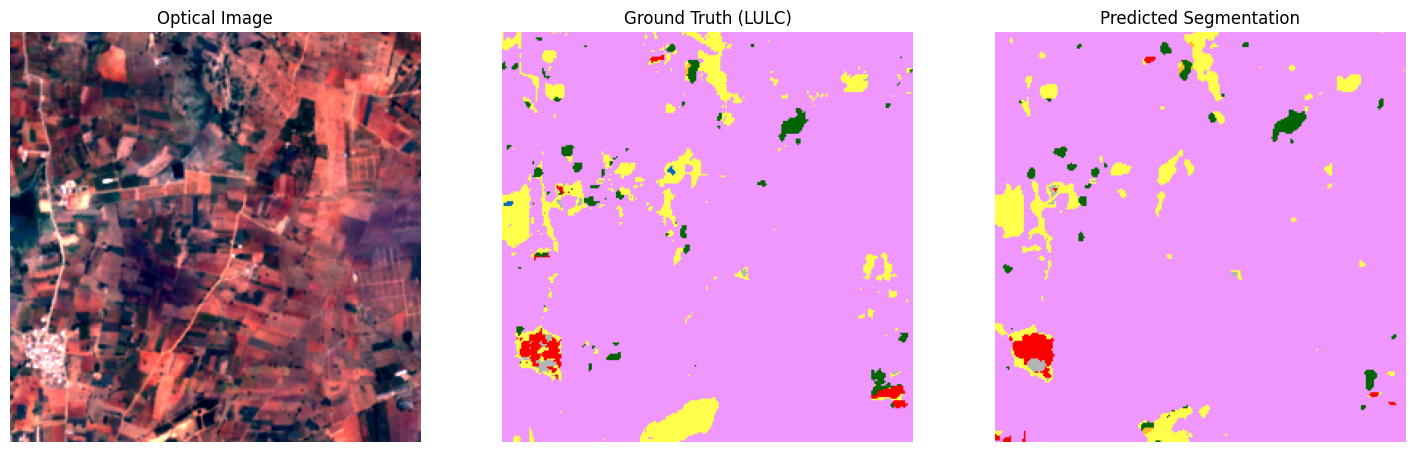

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test Image 5: /kaggle/input/kaggle/original_patches/assalu_patch_1004.tif
Label Image 5: /kaggle/input/kaggle/label_patches/label_patch_1004.tif
Predicted class shape: (256, 256)


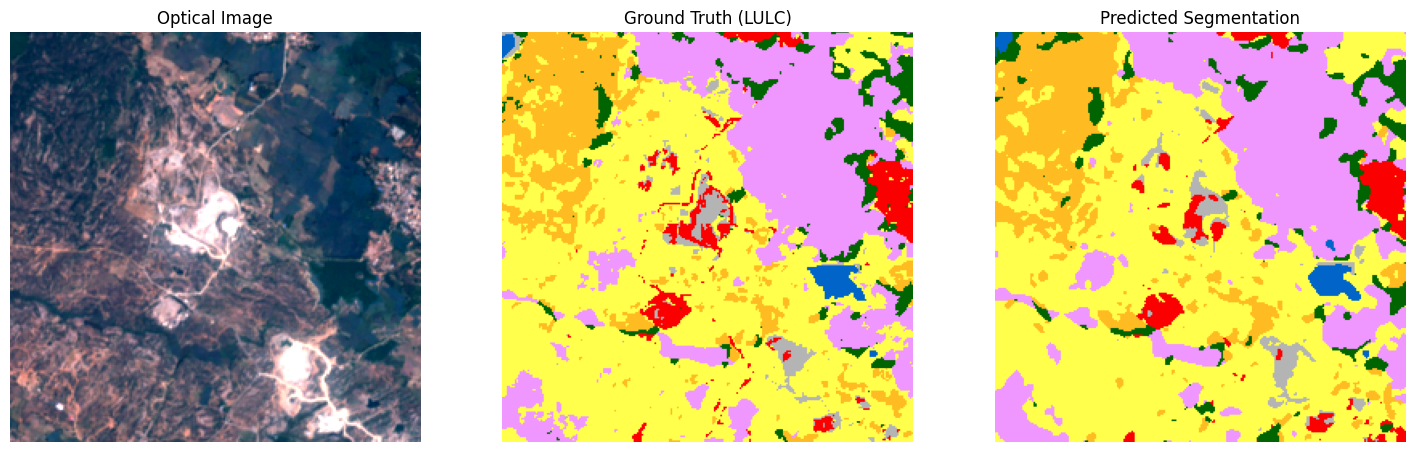

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

LULC_COLORS = { 
    10: ("Tree Cover", (0, 100, 0)),       # Dark Green
    20: ("Shrubland", (255, 187, 34)),     # Orange
    30: ("Grassland", (255, 255, 76)),     # Yellow
    40: ("Cropland", (240, 150, 255)),     # Pink
    50: ("Built-up", (250, 0, 0)),         # Red
    60: ("Bare/Sparse Vegetation", (180, 180, 180)),  # Gray
    80: ("Permanent Water Bodies", (0, 100, 200)),  # Dark Blue
}

CLASS_MAPPING = {
    0: 10,  # Tree Cover
    1: 20,  # Shrubland
    2: 30,  # Grassland
    3: 40,  # Cropland
    4: 50,  # Built-up
    5: 60,  # Bare/Sparse Vegetation
    6: 80   # Water Bodies
}

def normalize_optical_image(optical_data):
    """Normalize the optical image dynamically using percentile stretching."""
    min_val, max_val = np.percentile(optical_data, (2, 98))  # Adjust dynamic range
    normalized = np.clip((optical_data - min_val) / (max_val - min_val), 0, 1)
    return normalized.astype(np.float32)

def map_classes(predicted_mask, class_mapping):
    """Maps model output classes to ESA LULC classes."""
    mapped_mask = np.copy(predicted_mask)  # Create a copy to avoid modifying original data
    for model_class, esa_class in class_mapping.items():
        mapped_mask[predicted_mask == model_class] = esa_class
    return mapped_mask

def apply_colormap(mask, color_dict):
    """Applies colormap to a class mask and ensures black areas are replaced with blue."""
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, (_, color) in color_dict.items():
        rgb_mask[mask == class_id] = color  # Apply color mapping correctly

    # Ensure that any black areas are converted to blue (for water bodies)
    black_pixels = (rgb_mask[:, :, 0] == 0) & (rgb_mask[:, :, 1] == 0) & (rgb_mask[:, :, 2] == 0)
    rgb_mask[black_pixels] = (0, 100, 200)  # Replace black with blue

    return rgb_mask


def load_label_image(label_path):
    """Loads the ground truth label image."""
    with rasterio.open(label_path) as src:
        label_data = src.read(1)  # Assuming single-channel label image
    return label_data

def visualize_results(optical_img, ground_truth, pred_class):
    """Displays Optical Image, Ground Truth, and Predicted Segmentation."""
    if optical_img.ndim == 3 and optical_img.shape[0] == 3:
        optical_img = np.moveaxis(optical_img, 0, -1)  # Convert (C, H, W) → (H, W, C)

    normalized_optical_img = normalize_optical_image(optical_img)

    # Convert ground truth and predicted classes to ESA LULC classes
    gt_mapped = map_classes(ground_truth, CLASS_MAPPING)
    pred_mapped = map_classes(pred_class, CLASS_MAPPING)

    # Apply ESA color map
    gt_colored = apply_colormap(gt_mapped, LULC_COLORS)
    pred_colored = apply_colormap(pred_mapped, LULC_COLORS)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(normalized_optical_img, vmin=0, vmax=1)
    ax[0].set_title("Optical Image")
    ax[0].axis("off")

    ax[1].imshow(gt_colored)
    ax[1].set_title("Ground Truth (LULC)")
    ax[1].axis("off")

    ax[2].imshow(pred_colored)
    ax[2].set_title("Predicted Segmentation")
    ax[2].axis("off")

    plt.show()

# Process test images and labels
for i, (test_image_path, test_label_path) in enumerate(zip(test_optical_files[:5], test_label_files[:5])):
    try:
        # Load optical image
        optical_data = segmentation.load_optical_data(test_image_path)
        processed_image = segmentation.preprocess_optical(optical_data)
        
        # Load ground truth label
        label_data = load_label_image(test_label_path)

        # Run model prediction
        prediction = segmentation.model.predict(np.expand_dims(processed_image, axis=0))

        # Ensure correct shape before applying argmax
        if prediction.ndim == 4:
            pred_class = np.argmax(prediction.squeeze(), axis=-1)  # Removes batch dim if present
        else:
            raise ValueError(f"Unexpected prediction shape: {prediction.shape}")

        print(f"Test Image {i+1}: {test_image_path}")
        print(f"Label Image {i+1}: {test_label_path}")
        print(f"Predicted class shape: {pred_class.shape}")

        if pred_class.ndim != 2:
            raise ValueError(f"Expected a 2D prediction map, but got shape: {pred_class.shape}")

        # Display results
        visualize_results(processed_image, label_data, pred_class)

    except Exception as e:
        print(f"Error processing image {i+1}: {e}")


In [ ]:
def predict_new_image(image_path, segmentation_model):
    """Loads an optical image, processes it, runs prediction, and visualizes the result."""
    try:
        # Load and preprocess image
        optical_data = segmentation_model.load_optical_data(image_path)
        processed_image = segmentation_model.preprocess_optical(optical_data)

        # Run model prediction
        prediction = segmentation_model.model.predict(np.expand_dims(processed_image, axis=0))

        # Ensure correct shape before applying argmax
        if prediction.ndim == 4:
            pred_class = np.argmax(prediction.squeeze(), axis=-1)  # Removes batch dim if present
        else:
            raise ValueError(f"Unexpected prediction shape: {prediction.shape}")

        print(f"Processed New Image: {image_path}")
        print(f"Predicted class shape: {pred_class.shape}")

        if pred_class.ndim != 2:
            raise ValueError(f"Expected a 2D prediction map, but got shape: {pred_class.shape}")

        # Visualize results
        visualize_prediction_only(processed_image, pred_class)

    except Exception as e:
        print(f"Error processing image: {image_path}, Error: {e}")


In [ ]:
def visualize_prediction_only(optical_img, pred_class):
    """Displays Optical Image and Predicted Segmentation (No Ground Truth)."""
    if optical_img.ndim == 3 and optical_img.shape[0] == 3:
        optical_img = np.moveaxis(optical_img, 0, -1)  # Convert (C, H, W) → (H, W, C)

    normalized_optical_img = normalize_optical_image(optical_img)

    # Convert predicted classes to ESA LULC classes
    pred_mapped = map_classes(pred_class, CLASS_MAPPING)
    pred_colored = apply_colormap(pred_mapped, LULC_COLORS)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(normalized_optical_img, vmin=0, vmax=1)
    ax[0].set_title("Optical Image")
    ax[0].axis("off")

    ax[1].imshow(pred_colored)
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis("off")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processed New Image: /kaggle/input/asalu12/Optical_256x256_Karimnagar.tif
Predicted class shape: (256, 256)


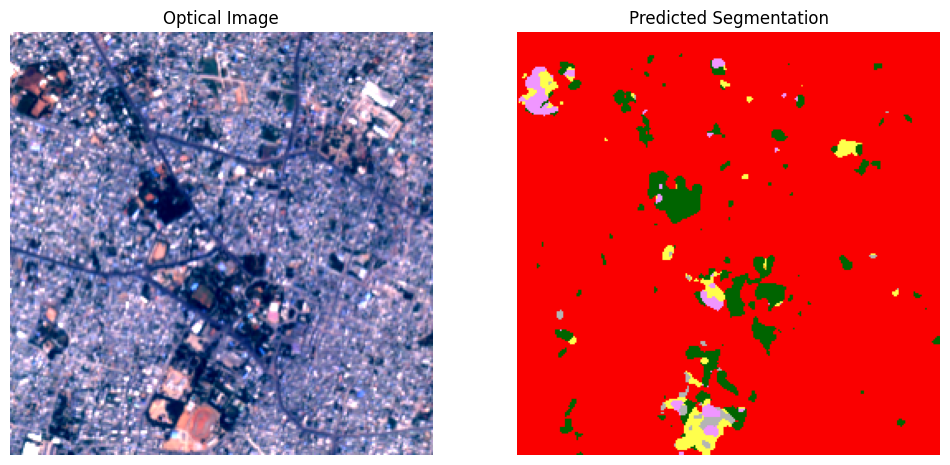

In [ ]:
new_image_path = "/kaggle/input/asalu12/Optical_256x256_Karimnagar.tif"
predict_new_image(new_image_path, segmentation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Processed New Image: /kaggle/input/weights-warangal/Optical_256x256_Warangal_Up.tif
Predicted class shape: (256, 256)


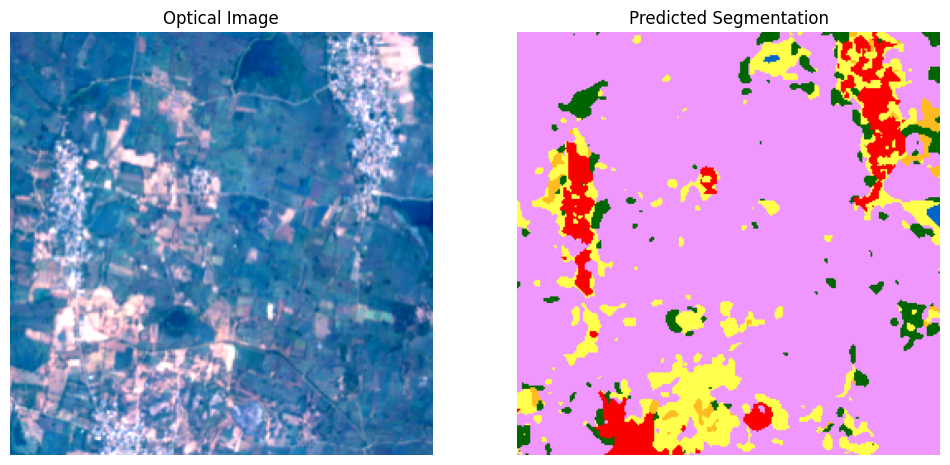

In [ ]:
new_image_path = "/kaggle/input/weights-warangal/Optical_256x256_Warangal_Up.tif"
predict_new_image(new_image_path, segmentation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Processed New Image: /kaggle/input/nellore/Sentinel2_Lake_Nellore.tif
Predicted class shape: (256, 256)


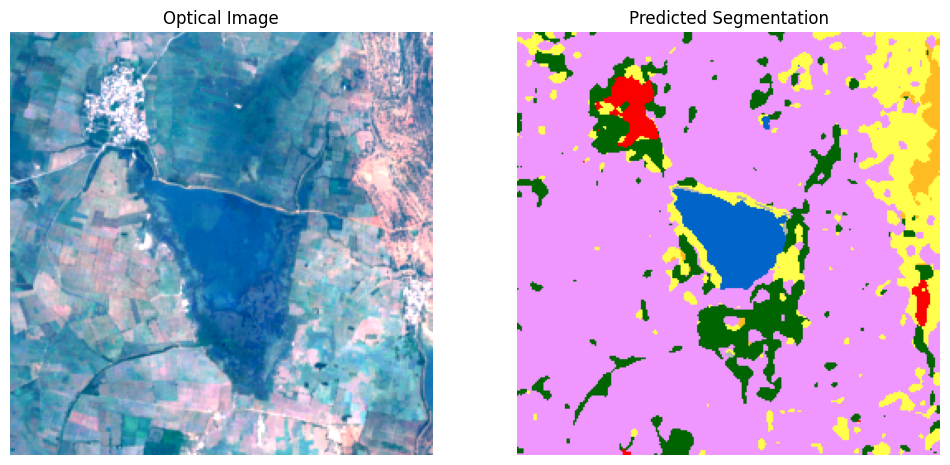

In [ ]:
new_image_path = "/kaggle/input/nellore/Sentinel2_Lake_Nellore.tif"
predict_new_image(new_image_path, segmentation)


Visualzing original and  labelled image

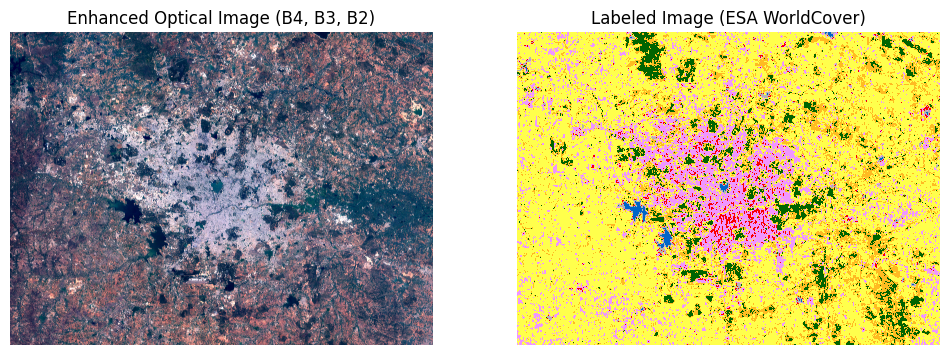

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def stretch_contrast(img, lower_percent=2, upper_percent=98):
    """Performs contrast stretching on an image using percentile-based clipping."""
    p_low, p_high = np.percentile(img, (lower_percent, upper_percent))
    img = np.clip((img - p_low) / (p_high - p_low + 1e-8), 0, 1)
    return img

def visualize_optical_esa(optical_path, esa_path):
    """Loads and visualizes Sentinel-2 Optical Image (RGB) and ESA WorldCover mask."""
    try:
        # Load Sentinel-2 Optical Image (B4, B3, B2 → R, G, B)
        with rasterio.open(optical_path) as src:
            optical_img = src.read([1, 2, 3]).astype(np.float32)  # Read available bands
            optical_img = np.transpose(optical_img, (1, 2, 0))  # Convert (C, H, W) → (H, W, C)
            optical_img = stretch_contrast(optical_img)  # Apply contrast stretching

        # Load ESA WorldCover classification mask
        with rasterio.open(esa_path) as src:
            labeled = src.read(1).astype(np.uint8)  # Read classification map

        # Define ESA WorldCover colormap
        class_colors = {
            10: ("Tree Cover", (0, 100, 0)),       # Dark Green
            20: ("Shrubland", (255, 187, 34)),     # Orange
            30: ("Grassland", (255, 255, 76)),     # Yellow
            40: ("Cropland", (240, 150, 255)),     # Pink
            50: ("Built-up", (250, 0, 0)),         # Red
            60: ("Bare/Sparse Vegetation", (180, 180, 180)),  # Gray
            80: ("Permanent Water Bodies", (0, 100, 200))     # Blue
        }

        from matplotlib.colors import ListedColormap, BoundaryNorm

        # Normalize RGB values to [0,1]
        normalized_colors = {k: (v[0], np.array(v[1])/255.0) for k, v in class_colors.items()}

        # Create colormap
        cmap = ListedColormap([normalized_colors[val][1] for val in sorted(normalized_colors.keys())])
        norm = BoundaryNorm(list(sorted(normalized_colors.keys())) + [100], cmap.N)



        # Plot the images
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Optical image
        axes[0].imshow(optical_img)
        axes[0].set_title("Enhanced Optical Image (B4, B3, B2)")
        axes[0].axis("off")

        # Labeled image (ESA WorldCover)
        im = axes[1].imshow(labeled, cmap=cmap, norm=norm)
        axes[1].set_title("Labeled Image (ESA WorldCover)")
        axes[1
        ].axis("off")


        plt.show()

    except Exception as e:
        print(f"Error loading images: {e}")

# Example usage
optical_image_path = r"C:\Users\supri\Downloads\asalu_image21.tif"
esa_worldcover_path = r"C:\Users\supri\Downloads\nrsc\cropped_labelled.tif"

visualize_optical_esa(optical_image_path, esa_worldcover_path)


Creating patches from orooginal and labelled image

In [ ]:
import rasterio
import numpy as np
import os
from rasterio.windows import Window

def extract_patches(image_path, label_path, output_dir, patch_size=256, stride=128):
    """
    Extract patches from an image and its corresponding label, ensuring alignment.
    
    Args:
        image_path: Path to the original optical image
        label_path: Path to the label TIF file
        output_dir: Directory to save output patches
        patch_size: Size of square patches (default: 256)
        stride: Step size between patches (default: 128)
    """
    # Create output directories for original and labeled patches
    output_image_dir = os.path.join(output_dir, 'original_patches')
    output_label_dir = os.path.join(output_dir, 'label_patches')
    
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)
    
    # Open both raster files
    with rasterio.open(image_path) as img_src, rasterio.open(label_path) as lbl_src:
        img_height, img_width = img_src.height, img_src.width
        lbl_height, lbl_width = lbl_src.height, lbl_src.width

        # Check if dimensions match
        if (img_height, img_width) != (lbl_height, lbl_width):
            raise ValueError("Error: Image and label dimensions do not match!")

        patch_count = 0
        for y in range(0, img_height - patch_size + 1, stride):
            for x in range(0, img_width - patch_size + 1, stride):
                window = Window(x, y, patch_size, patch_size)

                # Read image patch
                img_patch = img_src.read(window=window)

                # Read label patch
                lbl_patch = lbl_src.read(window=window)

                # Metadata update for saving patches
                img_meta = img_src.meta.copy()
                lbl_meta = lbl_src.meta.copy()

                img_meta.update({
                    'height': patch_size,
                    'width': patch_size,
                    'transform': rasterio.windows.transform(window, img_src.transform)
                })
                
                lbl_meta.update({
                    'height': patch_size,
                    'width': patch_size,
                    'transform': rasterio.windows.transform(window, lbl_src.transform)
                })

                # Save patches with matching names
                img_patch_path = os.path.join(output_image_dir, f'patch_{patch_count}.tif')
                lbl_patch_path = os.path.join(output_label_dir, f'patch_{patch_count}.tif')

                with rasterio.open(img_patch_path, 'w', **img_meta) as dst:
                    dst.write(img_patch)

                with rasterio.open(lbl_patch_path, 'w', **lbl_meta) as dst:
                    dst.write(lbl_patch)

                patch_count += 1

        print(f"✅ Created {patch_count} patches in '{output_image_dir}' and '{output_label_dir}'.")

# Example usage
if __name__ == "__main__":
    original_image_path = r"C:\Users\supri\Downloads\asalu_image21.tif" # Replace with actual path
    label_image_path = r"C:\Users\supri\Downloads\nrsc\cropped_labelled.tif"
    output_directory = r"C:\Users\supri\Downloads\nrsc\outcome"  # Replace with output folder

    extract_patches(original_image_path, label_image_path, output_directory)
    print("✅ Patching completed successfully!")


In [ ]:

#code for optical and labelled gee

// Define the time range
var startDate = '2023-01-01';
var endDate = '2023-12-31';

// Define the Area of Interest (AOI) - Ensure it's correctly set

// Load ESA WorldCover dataset
var worldCover = ee.Image("ESA/WorldCover/v200/2021").select('Map');

// Define visualization parameters for WorldCover
var worldCoverVis = {
  min: 10,
  max: 95,
  palette: [
    '006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 
    'b4b4b4', 'f0f0f0', '0064c8', '0096a0', '00cf75', 'fae6a0'
  ]
};

// Add WorldCover layer
Map.centerObject(aoi, 6);
Map.addLayer(worldCover.clip(aoi), worldCoverVis, 'ESA WorldCover 10m');

// Export WorldCover
Export.image.toDrive({
  image: worldCover.clip(aoi),
  description: 'ESA_WorldCover_2021_India',
  scale: 10,
  region: aoi,
  fileFormat: 'GeoTIFF',
  maxPixels: 1e13
});

// Load Sentinel-2 Optical collection and Clip to AOI
var sentinel2 = ee.ImageCollection('COPERNICUS/S2')
  .filterBounds(aoi)
  .filterDate(startDate, endDate)
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
  .select(['B4', 'B3', 'B2']); // Select RGB bands

// Create an optical composite image (median) and resize to match AOI
var opticalComposite = sentinel2.median().clip(aoi);

// Visualize Optical composite
var opticalVis = {min: 0, max: 3000, bands: ['B4', 'B3', 'B2']};
Map.addLayer(opticalComposite, opticalVis, 'Optical Composite (Resized)');

// Export Optical composite, ensuring it matches the AOI boundary exactly
Export.image.toDrive({
  image: opticalComposite,
  description: 'Optical_High_Resolution',
  folder: 'GEE_Exports',
  fileNamePrefix: 'Optical_High_Res',
  region: aoi,
  scale: 10,
  crs: 'EPSG:4326',
  maxPixels: 1e13
});





In [ ]:
# code for patchess




import rasterio
import numpy as np
import os
from rasterio.windows import Window

def extract_patches(image_path, label_path, output_dir, patch_size=256, stride=128):
    """
    Extract patches from an image and its corresponding label, ensuring alignment.
    
    Args:
        image_path: Path to the original optical image
        label_path: Path to the label TIF file
        output_dir: Directory to save output patches
        patch_size: Size of square patches (default: 256)
        stride: Step size between patches (default: 128)
    """
    # Create output directories for original and labeled patches
    output_image_dir = os.path.join(output_dir, 'original_patches')
    output_label_dir = os.path.join(output_dir, 'label_patches')
    
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)
    
    # Open both raster files
    with rasterio.open(image_path) as img_src, rasterio.open(label_path) as lbl_src:
        img_height, img_width = img_src.height, img_src.width
        lbl_height, lbl_width = lbl_src.height, lbl_src.width

        # Check if dimensions match
        if (img_height, img_width) != (lbl_height, lbl_width):
            raise ValueError("Error: Image and label dimensions do not match!")

        patch_count = 1  # Start count from 1
        for y in range(0, img_height - patch_size + 1, stride):
            for x in range(0, img_width - patch_size + 1, stride):
                window = Window(x, y, patch_size, patch_size)

                # Read image patch
                img_patch = img_src.read(window=window)

                # Read label patch
                lbl_patch = lbl_src.read(window=window)

                # Metadata update for saving patches
                img_meta = img_src.meta.copy()
                lbl_meta = lbl_src.meta.copy()

                img_meta.update({
                    'height': patch_size,
                    'width': patch_size,
                    'transform': rasterio.windows.transform(window, img_src.transform)
                })
                
                lbl_meta.update({
                    'height': patch_size,
                    'width': patch_size,
                    'transform': rasterio.windows.transform(window, lbl_src.transform)
                })

                # Save patches with modified names
                img_patch_path = os.path.join(output_image_dir, f'assalu_patch_{patch_count}.tif')
                lbl_patch_path = os.path.join(output_label_dir, f'label_patch_{patch_count}.tif')

                with rasterio.open(img_patch_path, 'w', **img_meta) as dst:
                    dst.write(img_patch)

                with rasterio.open(lbl_patch_path, 'w', **lbl_meta) as dst:
                    dst.write(lbl_patch)

                patch_count += 1

        print(f"✅ Created {patch_count - 1} patches in '{output_image_dir}' and '{output_label_dir}'.")

# Example usage
if __name__ == "__main__":
    original_image_path = r"C:\Users\supri\Downloads\asalu_image21.tif"  # Replace with actual path
    label_image_path = r"C:\Users\supri\Downloads\nrsc\cropped_labelled.tif"
    output_directory = r"C:\Users\supri\Downloads\nrsc\outcomes_pics"  # Replace with output folder

    extract_patches(original_image_path, label_image_path, output_directory)
    print("✅ Patching completed successfully!")











In [ ]:


# code for new image optical - Sentinel2

// Define an AOI adjusted to capture one lake near South Mopur, Nellore, Andhra Pradesh

// Define the time range for latest cloud-free data
var startDate = '2023-01-01';
var endDate = '2023-12-31';

// Load Sentinel-2 dataset
var sentinel2 = ee.ImageCollection('COPERNICUS/S2')
  .filterBounds(aoi)
  .filterDate(startDate, endDate)
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) // Low clouds = better clarity
  .select(['B4', 'B3', 'B2']);  // Selecting Red, Green, Blue bands

// Create a median composite and clip to AOI
var opticalComposite = sentinel2.median().clip(aoi);

// Visualization parameters for Sentinel-2 RGB
var visParams = {
  min: 0,
  max: 3000,
  bands: ['B4', 'B3', 'B2']
};

// Center Map on new AOI (adjusted for lake visibility)
Map.centerObject(aoi, 15);
Map.addLayer(opticalComposite, visParams, 'Sentinel-2 Image (Lake near South Mopur, Nellore)');

// Export Sentinel-2 Image (256x256 pixels, ~2.56km x 2.56km)
Export.image.toDrive({
  image: opticalComposite,
  description: 'Sentinel2_256x256_Lake_South_Mopur_Nellore',
  folder: 'GEE_Exports',
  fileNamePrefix: 'Sentinel2_Lake_South_Mopur_Nellore_256x256',
  region: aoi,
  scale: 10,  // Sentinel-2 has 10m resolution for RGB bands
  crs: 'EPSG:4326',
  maxPixels: 1e6  // Ensures large-area processing
});

